### **1. Pre-Setup**

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O cats_and_dogs_filtered.zip

--2023-11-10 08:37:37--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  19.9MB/s    in 4.0s    

2023-11-10 08:37:42 (16.5 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!mkdir 'data'

In [3]:
!unzip 'cats_and_dogs_filtered.zip' -d 'data'

Archive:  cats_and_dogs_filtered.zip
   creating: data/cats_and_dogs_filtered/
  inflating: data/cats_and_dogs_filtered/vectorize.py  
   creating: data/cats_and_dogs_filtered/validation/
   creating: data/cats_and_dogs_filtered/train/
   creating: data/cats_and_dogs_filtered/validation/dogs/
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/d

In [6]:
import os

base_dir = os.path.join('data', 'cats_and_dogs_filtered')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [7]:
print('Number of training examples of Cats:', len(os.listdir(train_cats_dir)))
print('Number of training examples of Dogs:', len(os.listdir(train_dogs_dir)))
print('Number of testing examples of cats:', len(os.listdir(validation_cats_dir)))
print('Number of testing examples of Dogs:', len(os.listdir(validation_dogs_dir)))

Number of training examples of Cats: 1000
Number of training examples of Dogs: 1000
Number of testing examples of cats: 500
Number of testing examples of Dogs: 500


### **2. Loading the Data**

In [10]:
import torch
from torchvision import transforms, datasets, models
import numpy as np
from torch import nn, optim
from PIL import Image

import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

**Lets Create DataLoaders along with some Data Augmentation on the Input data.**


In [9]:
from sklearn.utils import shuffle
# We create the transforms for train (Data Augmentation)
train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                           std = [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                          std = [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(train_dir, transform = train_transform)
test_dataset = datasets.ImageFolder(validation_dir, transform = test_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 128)

<Axes: >

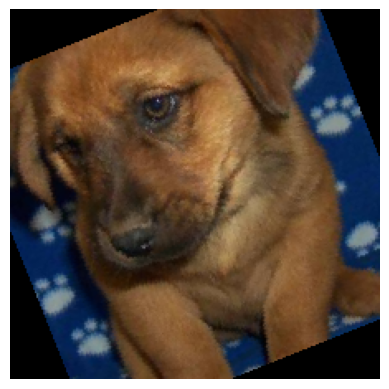

In [12]:
def imshow(image, ax = None, title = None, normalize = True):
  """Imshow for Tensor."""
  if ax is None:
    fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))

  if normalize:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis = 'both', length = 0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')

  return ax

images, labels = next(iter(train_dataloader))
title = 'Dog' if labels[0].item() == 1 else 'Cat'
imshow(images[0])

### **3. Loading the Pre-Trained model**

**We are going to be using the Densenet 121 model**

In [13]:
model = models.vgg16(weights=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 67.7MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We can see that the model has to major components which are the *Features* and the *Classifier*.

The *Features* are obtained by passing the image throught the many Convolutions

The *Classifier* is built and trained to the "Imagenet" dataset so it has about 1000 neurons in the output layer as it can map upto 1000 different classes.

For out Cats-Dogs classifier we need to train a binary classifier and can train a new classifier from scratch which uses the features learnt from the "Imagenet" dataset of the Densenet121

In [15]:
# Freeze our feature parameters as we don't wanna retrain them to the new data
for param in model.parameters():
  param.requires_grad = False

**Lets now build our binary classifier**

In [16]:
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([# Layer 1
                                        ('dropout1', nn.Dropout(0.3)),
                                        ('fc1', nn.Linear(25088, 500)),
                                        ('relu', nn.ReLU()),
                                        # Output layer
                                        ('fc2', nn.Linear(500, 2)),
                                        ('output', nn.LogSoftmax(dim = 1))]))
# Attach the classifier to the model
model.classifier = classifier

### **4. Train the Model**

In [17]:
# Loss
criterion = nn.NLLLoss()

# Optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

In [18]:
# Lets use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [19]:
# Moving model to GPU
model = model.to(device)

In [20]:
from tqdm import  tqdm
epochs = 5

for e in range(epochs):
  running_loss, total, correct = 0, 0, 0

  model.train()

  for images, labels in tqdm(train_dataloader):

    # Moving input to GPU
    images, labels = images.to(device), labels.to(device)

    # Forward prop
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward prop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Metrics
    running_loss += loss.item()
    total += labels.size(0)

    _, predicted = torch.max(torch.exp(outputs).data, 1)
    correct += (predicted == labels).sum().item()
  else:
    # Logs
    print(f'Epoch {e} Training: Loss={running_loss:.5f} Acc={correct/total * 100:.2f}')


100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


Epoch 0 Training: Loss=4.89186 Acc=90.90


100%|██████████| 16/16 [00:19<00:00,  1.22s/it]


Epoch 1 Training: Loss=1.63067 Acc=96.65


100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


Epoch 2 Training: Loss=1.64897 Acc=96.80


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Epoch 3 Training: Loss=1.21459 Acc=97.50


100%|██████████| 16/16 [00:18<00:00,  1.13s/it]

Epoch 4 Training: Loss=1.28027 Acc=97.35


### **5. Save the model**

In [22]:
# The checkpoints dictionary will consist of necessary details for rebuilding
# the model with pretrained weights
checkpoint = {'pre_trained':'vgg16',
              'classifier': nn.Sequential(OrderedDict([ # Layer 1
                                                       ('dropout1', nn.Dropout(0.3)),
                                                        ('fc1', nn.Linear(25088, 500)),
                                                        ('relu', nn.ReLU()),
                                                        # Output layer
                                                        ('fc2', nn.Linear(500, 2)),
                                                        ('Output', nn.LogSoftmax(dim = 1))])),
              'state_dict': model.state_dict()}
torch.save(checkpoint, 'vgg16_catsVdogs.pth')

In [25]:
# Loading and Rebuilding the saved model

def load_saved_model(path):
  # Loading the checkpoint dictionary
  checkpoint = torch.load(path)
  # Loading features of the pretrained vgg16
  model = models.vgg16(weights = True)
  for param in model.parameters():
    param.requires_grad = False

  # Reconstruct the classifier by loading the structure from checkpoint
  model.classifier = checkpoint['classifier']
  # Loading the weights
  model.load_state_dict(checkpoint['state_dict'])
  # Set model to Evaluation mode to avoid training
  model.eval()

  return model

In [26]:
loaded_model = load_saved_model('vgg16_catsVdogs.pth')
loaded_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
loaded_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### **6. Testing and creating submission**

**Prediction**

In [28]:
import glob
directory = 'data'
files = glob.glob(f'{directory}/cats_and_dogs_filtered/validation/**/*.jpg', recursive=True)
# data/cats_and_dogs_filtered/validation/cats/cat.2000.jpg
print(len(files))
print(files[0])
print(files[0].split("/")[2])

1000
data/cats_and_dogs_filtered/validation/cats/cat.2414.jpg
validation


In [29]:
# Test transforms
test_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                         std = [0.229, 0.224, 0.225])])
predictions = []
for path in tqdm(files):
  x = Image.open(path).convert('RGB')
  x = test_transform(x)[:3,:,:]
  x = x.unsqueeze(0)
  x = x.to(device)
  outputs = loaded_model(x)
  predictions.append(torch.argmax(outputs).item())

100%|██████████| 1000/1000 [00:10<00:00, 91.72it/s]


In [30]:
def get_predictions(model, iterator):
  model.eval()

  images = []
  labels = []
  probs = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)

      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)

      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())

  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)

  return images, labels, probs

In [31]:
images, labels, probs = get_predictions(loaded_model, test_dataloader)

In [32]:
pred_labels = torch.argmax(probs, 1)

In [33]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize = (5, 5));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 10)
    plt.ylabel('True Label', fontsize = 10)

In [34]:
classes = test_dataset.classes

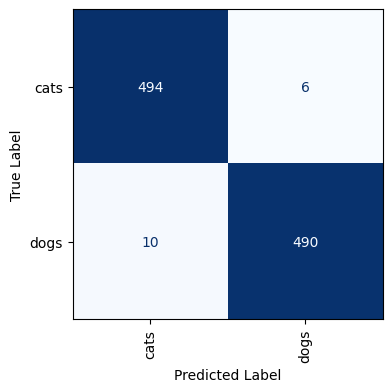

In [35]:
plot_confusion_matrix(labels, pred_labels, classes)

In [36]:
corrects = torch.eq(labels, pred_labels)

In [37]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [38]:
import numpy as np

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

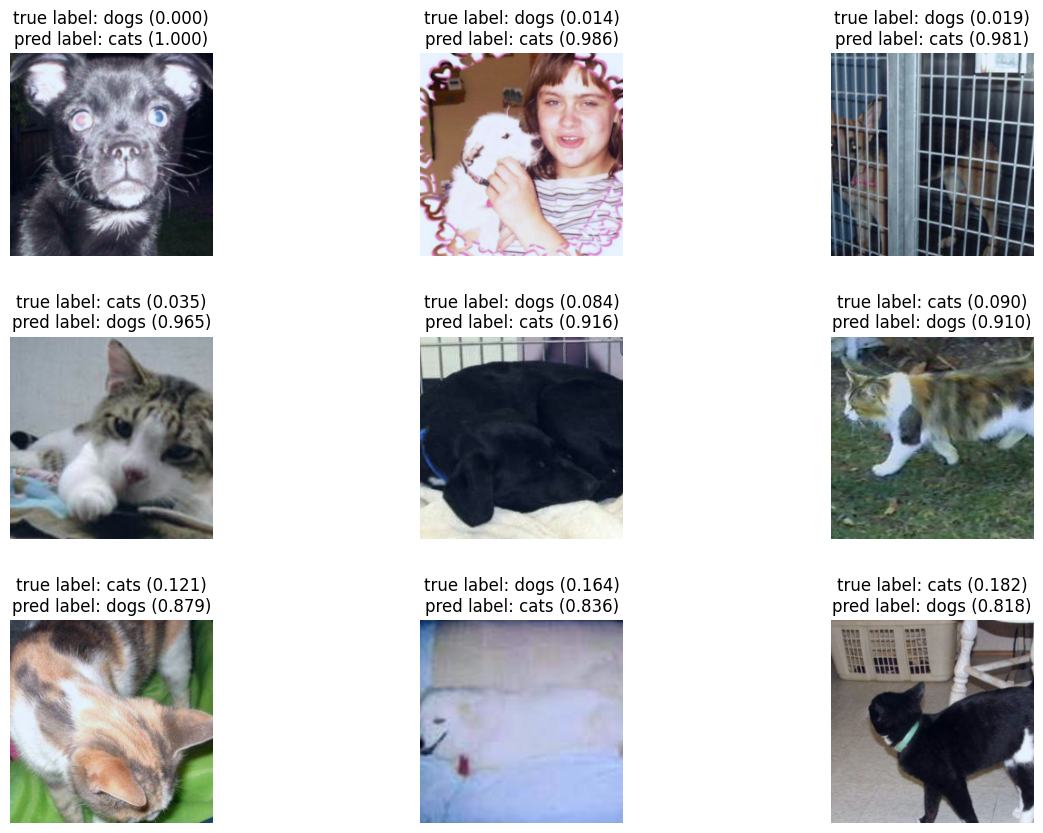

In [39]:
N_IMAGES = 15

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)